In [ ]:
import imageio as iio
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Random Erasing

In [ ]:
def randomErasing(image, size, probability, areaRatio, aspectRatio, occlusion_color):
    p1 = np.random.uniform(0, 1)
    # With probability p pick randomly erases occlusion area
    if p1 >= probability:
        return image
    else:
        res = image.copy()
        channels = image.shape[0]
        while True:
            W,H = size[0], size[1]
            area = W * H
            Se = np.random.uniform(areaRatio[0],areaRatio[1],1)[0] * area
            re = np.random.uniform(aspectRatio[0],aspectRatio[1],1)[0]
            He = int(round(np.sqrt(Se * re)))
            We = int(round(np.sqrt(Se / re)))

            # Randomly generating top left corner
            xe = np.random.randint(0,W,1)[0]
            ye = np.random.randint(0,H,1)[0]

            # Selecting occlusion area
            if xe + We <= M and ye + He <= N:
                res[xe:xe+We, ye:ye+He] = occlusion_color
                return res
            # elif xe + We > W:
            #     res[:, ye:ye+He] = occlusion_color
            # elif ye + He > H:
            #     res[xe:xe+We,:] = occlusion_color
            # else:
            #     res[:,:] = occlusion_color

In [ ]:
sl = 0.02  # occlusion area length ratio
sh = 0.4   # occlusion area height ratio
r1 = 0.3   # occlusion area aspect ratio
occlusion_color = [234, 200, 189]
train = X_train.copy()
img = X_train[8990].copy()

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(28, 28)

In [ ]:
res = randomErasing(img, img.shape, 0.9, (sl, sh), (r1,1/r1), occlusion_color)

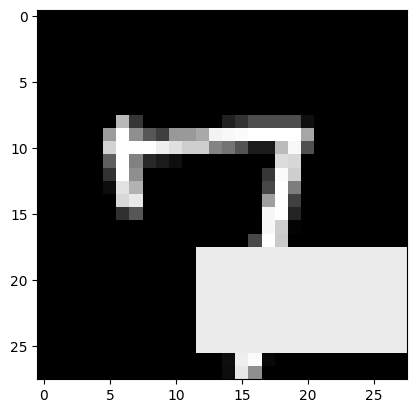

In [ ]:
plt.imshow(res,cmap='gray')

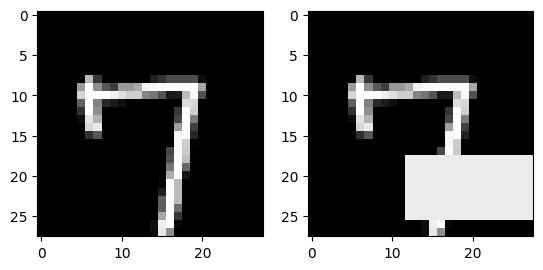

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img,cmap='gray')
axarr[1].imshow(res,cmap='gray')

### Bilinear Interpolation

In [ ]:
def occlusion_with_interpolation(img, box, occlusion_size, occlusion_color):
    img_np = img.astype(np.float32)
    img_np_origin = img_np.copy()

    height, width = img_np.shape[:2]
    x, y = box
    h, w = occlusion_size

    # Top left corner
    X0, Y0 = x, y
    # Bottom right corner
    X3, Y3 = min(x + w, width), min(y + h, height)

    i = Y0
    j = X0
    while i < Y3:
        while j < X3:
            # Four nearest pixels for (i,j): (floor(x), floor(y)), (floor(x), ceil(y)), (ceil(x), floor(y)), (ceil(x), ceil(y))
            x1 = int(np.floor(j))
            y1 = int(np.floor(i))
            x2 = int(np.ceil(j))
            y2 = int(np.ceil(i))

            pixel_x1_y1 = img_np_origin[y1, x1]
            pixel_x1_y2 = img_np_origin[y2, x1]
            pixel_x2_y1 = img_np_origin[y1, x2]
            pixel_x2_y2 = img_np_origin[y2, x2]

            # bilinear interpolation
            # if x1 == x2, then the coefficient of x-axis is 1
            # if y1 == y2, then the coefficient of y-axis is 1
            coefficient_x1 = 1 if x1 == x2 else (x2 - j) / (x2 - x1)
            coefficient_y1 = 1 if y1 == y2 else (y2 - i) / (y2 - y1)
            coefficient_x2 = 1 if x1 == x2 else (j - x1) / (x2 - x1)
            coefficient_y2 = 1 if y1 == y2 else (i - y1) / (y2 - y1)
            coefficient_x1_y1 = coefficient_x1 * coefficient_y1
            coefficient_x1_y2 = coefficient_x1 * coefficient_y2
            coefficient_x2_y1 = coefficient_x2 * coefficient_y1
            coefficient_x2_y2 = coefficient_x2 * coefficient_y2

            # If x1 != x2 and y1 != y2, assign both four points
            if x1 != x2 and y1 != y2:
                img_np[y1, x1] = img_np[y1, x1] - coefficient_x1_y1 * (pixel_x1_y1 - occlusion_color)
                img_np[y1, x2] = img_np[y1, x2] - coefficient_x2_y1 * (pixel_x2_y1 - occlusion_color)
                img_np[y2, x1] = img_np[y2, x1] - coefficient_x1_y2 * (pixel_x1_y2 - occlusion_color)
                img_np[y2, x2] = img_np[y2, x2] - coefficient_x2_y2 * (pixel_x2_y2 - occlusion_color)
            elif x1 == x2 and y1 == y2:
                img_np[y1, x1] = img_np[y1, x1] - coefficient_x1_y1 * (pixel_x1_y1 - occlusion_color)
            # If x1 == x2, only assign (y1, x1) and (y2, x1)
            elif x1 == x2:
                img_np[y1, x1] = img_np[y1, x1] - coefficient_x1_y1 * (pixel_x1_y1 - occlusion_color)
                img_np[y2, x1] = img_np[y2, x1] - coefficient_x1_y2 * (pixel_x1_y2 - occlusion_color)
            # Else if y1 == y2, only assign (y1, x1) and (y1, x2)
            elif y1 == y2:
                img_np[y1, x1] = img_np[y1, x1] - coefficient_x1_y1 * (pixel_x1_y1 - occlusion_color)
                img_np[y1, x2] = img_np[y1, x2] - coefficient_x2_y1 * (pixel_x2_y1 - occlusion_color)
            # Move to the next occlusion point
            j += 1
        # Move to the next occlusion point
        i += 1
        j = X0

    return img_np

In [ ]:
img = X_train[59597].copy()
a = 20.67
b = 9.7
w = 10
h = 5
occlusion_color = 234
res1 = occlusion_with_interpolation(img, (a,b), (w,h), occlusion_color)

In [ ]:
res1 = res1.astype(np.int32)

In [ ]:
cv2_imshow(res1)

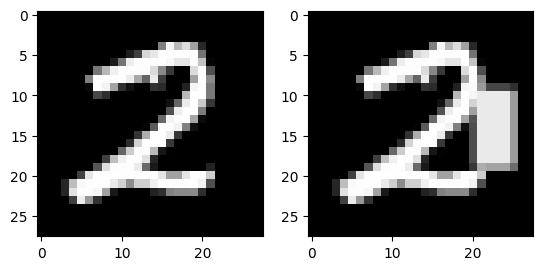

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img,cmap='gray')
axarr[1].imshow(res1,cmap='gray')